In [1]:
import requests
import random
import json
import os
import time
from http.cookiejar import LWPCookieJar
from datetime import datetime, timezone, timedelta
import pytz
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Circle
from typing import List, Dict, Any, Optional
import seaborn as sns
import numpy as np
from collections import Counter
from scipy.interpolate import interp1d

%matplotlib inline

In [2]:
STEAM_ID = 340440597  # Replace with the desired Steam ID
API_TOKEN = ""
MAX_MATCHES = 100  # Set to None to fetch all available matches

In [23]:
################################################################################################################
#                                                                                                              #
# Use with care, don't bombard with multiple requests as it will lead to ban by cloudflare security            #
# or worse, ban from the platform itself                                                                       #
#                                                                                                              #
#                                                                                                              #
################################################################################################################
class MatchFetcher:
    def __init__(self, steam_id: int, token: str, data_dir: str = "data"):
        self.steam_id = steam_id
        self.token = token
        self.data_dir = data_dir
        self.matches_file = os.path.join(data_dir, f"matches_{steam_id}.json")
        self.session = self._setup_session()

        # Create data directory if it doesn't exist
        os.makedirs(data_dir, exist_ok=True)

    def _setup_session(self):
        session = requests.Session()
        cookie_file = os.path.join(self.data_dir, "stratz_cookies.txt")
        session.cookies = LWPCookieJar(cookie_file)

        # Load existing cookies if they exist
        if os.path.exists(cookie_file):
            try:
                session.cookies.load(ignore_discard=True)
            except Exception as e:
                print(f"Could not load cookies: {e}")

        return session

    def _load_cached_matches(self) -> Dict:
        """Load matches from local cache file"""
        if os.path.exists(self.matches_file):
            try:
                with open(self.matches_file, 'r') as f:
                    data = json.load(f)
                print(f"Loaded {len(data['matches'])} matches from cache")
                return data
            except Exception as e:
                print(f"Error loading cached matches: {e}")
        return {"matches": [], "last_updated": None}

    def _save_matches(self, matches: List[Dict]):
        """Save matches to local cache file"""
        data = {
            "matches": matches,
            "last_updated": datetime.now().isoformat(),
            "steam_id": self.steam_id,
            "total_matches": len(matches)
        }
        try:
            with open(self.matches_file, 'w') as f:
                json.dump(data, f, indent=2)
            print(f"Saved {len(matches)} matches to {self.matches_file}")
        except Exception as e:
            print(f"Error saving matches: {e}")

    def fetch_matches(self, batch_size: int = 20, max_matches: int = None, force_refresh: bool = False) -> List[Dict[Any, Any]]:
        """
        Fetch matches with caching support

        Args:
            batch_size: Number of matches to fetch per request
            max_matches: Maximum number of matches to fetch in total
            force_refresh: If True, ignore cache and fetch fresh data
        """
        # Check cache first if not forcing refresh
        if not force_refresh:
            cached_data = self._load_cached_matches()
            if cached_data["matches"]:
                if max_matches:
                    return cached_data["matches"][:max_matches]
                return cached_data["matches"]

        # Common headers for all requests
        base_headers = {
            "Host": "api.stratz.com",
            "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:131.0) Gecko/20100101 Firefox/131.0",
            "Accept": "*/*",
            "Accept-Language": "en-US,en;q=0.5",
            "Accept-Encoding": "gzip, deflate, br, zstd",
            "Connection": "keep-alive",
            "Sec-Fetch-Dest": "empty",
            "Sec-Fetch-Mode": "no-cors",
            "Sec-Fetch-Site": "same-site",
            "Sec-GPC": "1",
            "TE": "trailers",
            "Pragma": "no-cache",
            "Cache-Control": "no-cache"
        }

        query = """
        query PlayerMatchesSummary($request: PlayerMatchesRequestType!, $steamId: Long!) {
          player(steamAccountId: $steamId) {
            steamAccountId
            matches(request: $request) {
              ...MatchRowSummary
              players(steamAccountId: $steamId) {
                ...MatchRowSummaryPlayer
                __typename
              }
              __typename
            }
            __typename
          }
        }
        fragment MatchRowBase on MatchType {
          id
          rank
          lobbyType
          gameMode
          endDateTime
          durationSeconds
          allPlayers: players {
            partyId
            __typename
          }
          league {
            id
            displayName
            __typename
          }
          analysisOutcome
          __typename
        }
        fragment MatchRowBasePlayer on MatchPlayerType {
          steamAccountId
          heroId
          role
          lane
          level
          isVictory
          isRadiant
          partyId
          __typename
        }
        fragment MatchRowSummary on MatchType {
          ...MatchRowBase
          bottomLaneOutcome
          midLaneOutcome
          topLaneOutcome
          pickBans {
            heroId
            isCaptain
            __typename
          }
          __typename
        }
        fragment MatchRowSummaryPlayer on MatchPlayerType {
          ...MatchRowBasePlayer
          imp
          award
          kills
          deaths
          assists
          item0Id
          item1Id
          item2Id
          item3Id
          item4Id
          item5Id
          __typename
        }
        """

        all_matches = []
        last_match_id = None
        retries = 3

        while True:
            variables = {
                "steamId": self.steam_id,
                "request": {
                    "skip": 0,
                    "take": batch_size
                }
            }
            if last_match_id:
                variables["request"]["before"] = last_match_id

            payload = {
                "operationName": "PlayerMatchesSummary",
                "variables": variables,
                "query": query
            }

            # API request headers
            api_headers = base_headers.copy()
            api_headers.update({
                "Referer": "https://stratz.com/",
                "Origin": "https://stratz.com",
                "content-type": "application/json",
                "authorization": f"Bearer {self.token}"
            })

            for attempt in range(retries):
                try:
                    response = self.session.post(
                        "https://api.stratz.com/graphql",
                        json=payload,
                        headers=api_headers
                    )
                    print(f"API Response Status: {response.status_code}")

                    response.raise_for_status()
                    data = response.json()
                    break

                except Exception as e:
                    print(f"Request failed (attempt {attempt + 1}): {e}")
                    if attempt == retries - 1:
                        # Save what we have if we're giving up
                        if all_matches:
                            self._save_matches(all_matches)
                        return all_matches

                    wait_time = (2 ** attempt) * 5
                    print(f"Waiting {wait_time} seconds before retry...")
                    time.sleep(wait_time)
                    continue

            if "errors" in data:
                print(f"GraphQL Error: {data['errors']}")
                break

            matches = data["data"]["player"]["matches"]
            if not matches:
                break

            all_matches.extend(matches)
            print(f"Fetched {len(all_matches)} matches so far.")

            if max_matches and len(all_matches) >= max_matches:
                all_matches = all_matches[:max_matches]
                break

            last_match_id = matches[-1]["id"]
            time.sleep(random.uniform(10, 15))

        # Save matches to file
        self._save_matches(all_matches)

        return all_matches

In [101]:
def fetch_matches(steam_id: int, token: str, batch_size: int = 20, max_matches: int = None, force_refresh: bool = False) -> List[Dict[Any, Any]]:
    """Convenience function to maintain backwards compatibility"""
    fetcher = MatchFetcher(steam_id, token)
    return fetcher.fetch_matches(batch_size, max_matches, force_refresh)

matches = fetch_matches(STEAM_ID, API_TOKEN, batch_size=100, max_matches=MAX_MATCHES)
print(f"\nFetched a total of {len(matches)} matches")

API Response Status: 403
Request failed (attempt 1): 403 Client Error: Forbidden for url: https://api.stratz.com/graphql

Fetched a total of 0 matches


In [4]:
def load_matches(steam_id: int, data_dir: str = "data") -> Optional[List[Dict]]:
    """
    Load matches from stored JSON file for a given Steam ID
    
    Args:
        steam_id: Steam ID of the player
        data_dir: Directory where match data is stored
    
    Returns:
        List of matches if file exists and is valid, None otherwise
    """
    file_path = os.path.join(data_dir, f"matches_{steam_id}.json")
    
    if not os.path.exists(file_path):
        print(f"No stored matches found for Steam ID {steam_id}")
        return None
    
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
            matches = data.get('matches', [])
            print(f"Loaded {len(matches)} matches from {file_path}")
            print(f"Last updated: {data.get('last_updated', 'unknown')}")
            return matches
            
    except Exception as e:
        print(f"Error loading matches: {e}")
        return None


matches = load_matches(steam_id=340440597)
if matches:
    print(f"Found {len(matches)} matches")

Loaded 3977 matches from data/matches_340440597.json
Last updated: 2024-10-22T20:47:35.012296
Found 3977 matches


In [5]:
def process_matches(matches: List[Dict[Any, Any]]) -> pd.DataFrame:
    kolkata_tz = pytz.timezone('Asia/Kolkata')
    
    data = []
    for match in matches:
        end_date = datetime.fromtimestamp(match['endDateTime'], tz=timezone.utc).astimezone(kolkata_tz).date()
        data.append({
            'date': end_date,
            'match_id': match['id'],
            'duration': match['durationSeconds'],
            'is_victory': match['players'][0]['isVictory'],
            'kills': match['players'][0]['kills'],
            'hero_id': match['players'][0]['heroId'],
            'deaths': match['players'][0]['deaths'],
            'assists': match['players'][0]['assists']
        })
    
    df = pd.DataFrame(data)
    df = df.sort_values('date')
    df['cumulative_matches'] = range(1, len(df) + 1)
    
    return df

df = process_matches(matches)

In [6]:
df

,date,match_id,duration,is_victory,kills,hero_id,deaths,assists,cumulative_matches
3976,2022-05-23,6583797972,1791,False,1,64,8,3,1
3973,2022-05-28,6590770465,2146,False,0,3,7,1,2
3975,2022-05-28,6589744045,2697,False,4,108,13,7,3
3974,2022-05-28,6590697895,2071,False,0,36,14,3,4
3972,2022-07-02,6644173675,2462,False,1,22,11,14,5
...,...,...,...,...,...,...,...,...,...
4,2024-10-21,7998153850,1295,False,5,68,8,6,3973
3,2024-10-21,7998223050,1147,False,2,79,8,6,3974
2,2024-10-22,7998255464,1704,True,6,101,6,20,3975
1,2024-10-22,7998365477,2197,False,4,86,11,28,3976


In [7]:
# Hero id / Ability Id constants is definied in a different place which is easily accessable via network calls
with open('dota_constants.json') as json_file:
    dota_constants = json.load(json_file)

In [8]:
hero_data_mapping = {}
for hero in dota_constants["heroes"]:
    hero_data_mapping[hero['id']] = { "name": hero['language']['displayName'], "attribute": hero['stats']['primaryAttribute']}

hero_data_mapping[131] = {'name': 'Ringmaster', 'attribute': 'int'}
hero_data_mapping

{1: {'name': 'Anti-Mage', 'attribute': 'agi'},
 2: {'name': 'Axe', 'attribute': 'str'},
 3: {'name': 'Bane', 'attribute': 'all'},
 4: {'name': 'Bloodseeker', 'attribute': 'agi'},
 5: {'name': 'Crystal Maiden', 'attribute': 'int'},
 6: {'name': 'Drow Ranger', 'attribute': 'agi'},
 7: {'name': 'Earthshaker', 'attribute': 'str'},
 8: {'name': 'Juggernaut', 'attribute': 'agi'},
 9: {'name': 'Mirana', 'attribute': 'all'},
 10: {'name': 'Morphling', 'attribute': 'agi'},
 11: {'name': 'Shadow Fiend', 'attribute': 'agi'},
 12: {'name': 'Phantom Lancer', 'attribute': 'agi'},
 13: {'name': 'Puck', 'attribute': 'int'},
 14: {'name': 'Pudge', 'attribute': 'str'},
 15: {'name': 'Razor', 'attribute': 'agi'},
 16: {'name': 'Sand King', 'attribute': 'all'},
 17: {'name': 'Storm Spirit', 'attribute': 'int'},
 18: {'name': 'Sven', 'attribute': 'str'},
 19: {'name': 'Tiny', 'attribute': 'str'},
 20: {'name': 'Vengeful Spirit', 'attribute': 'all'},
 21: {'name': 'Windranger', 'attribute': 'all'},
 22: {'n

In [9]:
# Prepare hero performance data
hero_data = df.groupby('hero_id').agg({
    'match_id': 'count',
    'is_victory': 'mean',
    'kills': 'mean',
    'deaths': 'mean',
    'assists': 'mean'
}).reset_index()

hero_data = hero_data[hero_data['match_id'] > 2]
# Safe KDA calculation
hero_data['kda'] = (hero_data['kills'] + hero_data['assists']) / hero_data['deaths'].replace(0, 1)
hero_data['kda'] = hero_data['kda'].clip(0, 20)  # Clip KDA to reasonable range
hero_data['primary_attr'] = hero_data['hero_id'].apply(lambda x: hero_data_mapping[x]['attribute'])

hero_data

,hero_id,match_id,is_victory,kills,deaths,assists,kda,primary_attr
0,2,17,0.647059,8.352941,8.235294,14.235294,2.742857,str
1,3,111,0.522523,2.720721,5.576577,14.972973,3.172859,all
2,4,7,0.285714,6.285714,7.428571,7.285714,1.826923,agi
3,5,38,0.447368,3.210526,7.236842,16.421053,2.712727,int
4,7,30,0.400000,4.266667,8.166667,12.333333,2.032653,str
...,...,...,...,...,...,...,...,...
97,131,15,0.733333,4.133333,6.266667,20.666667,3.957447,int
98,135,48,0.520833,5.395833,6.437500,14.041667,3.019417,str
99,136,32,0.468750,4.437500,7.656250,14.687500,2.497959,all
100,137,31,0.483871,4.774194,5.000000,12.225806,3.400000,str


In [10]:
# Useful while tagging point of interest heroes in graph
def get_top_heroes(hero_data):
    results = {}

    for attr in hero_data['primary_attr'].unique():
        attr_data = hero_data[hero_data['primary_attr'] == attr]

        # Top 3 with highest KDA
        top_kda = attr_data.nlargest(3, 'kda')

        # Top 3 with lowest KDA
        bottom_kda = attr_data.nsmallest(3, 'kda')

        # Top 2 with highest match count
        top_matches = attr_data.nlargest(2, 'match_id')

        results[attr] = {
            'top_kda': top_kda,
            'bottom_kda': bottom_kda,
            'top_matches': top_matches
        }

    return results

# Get the results
top_heroes = get_top_heroes(hero_data)

top_unique_heroes = set()
temp = []
for i in top_heroes.keys():
    print(f"For {i}")
    top_kda = list(top_heroes[i]['top_kda']['hero_id'])
    bottom_kda = list(top_heroes[i]['bottom_kda']['hero_id'])
    top_matches = list(top_heroes[i]['top_matches']['hero_id'])
    print([hero_data_mapping[i]['name'] for i in top_kda],
          [hero_data_mapping[i]['name'] for i in bottom_kda],
          [hero_data_mapping[i]['name'] for i in top_matches])
    temp += top_kda
    temp += bottom_kda
    temp += top_matches
    top_unique_heroes.update(top_kda)
    top_unique_heroes.update(bottom_kda)
    top_unique_heroes.update(top_matches)

set([x for x in temp if temp.count(x) > 1])

For str
['Tidehunter', 'Dragon Knight', 'Elder Titan'] ['Night Stalker', 'Earth Spirit', 'Earthshaker'] ['Mars', 'Legion Commander']
For all
['Abaddon', 'Mirana', 'Snapfire'] ['Magnus', 'Beastmaster', 'Clockwerk'] ['Dazzle', 'Bane']
For agi
['Spectre', 'Razor', 'Clinkz'] ['Sniper', 'Bloodseeker', 'Monkey King'] ['Faceless Void', 'Hoodwink']
For int
['Warlock', 'Ringmaster', 'Oracle'] ['Shadow Shaman', 'Death Prophet', 'Lion'] ['Rubick', 'Warlock']


{37}

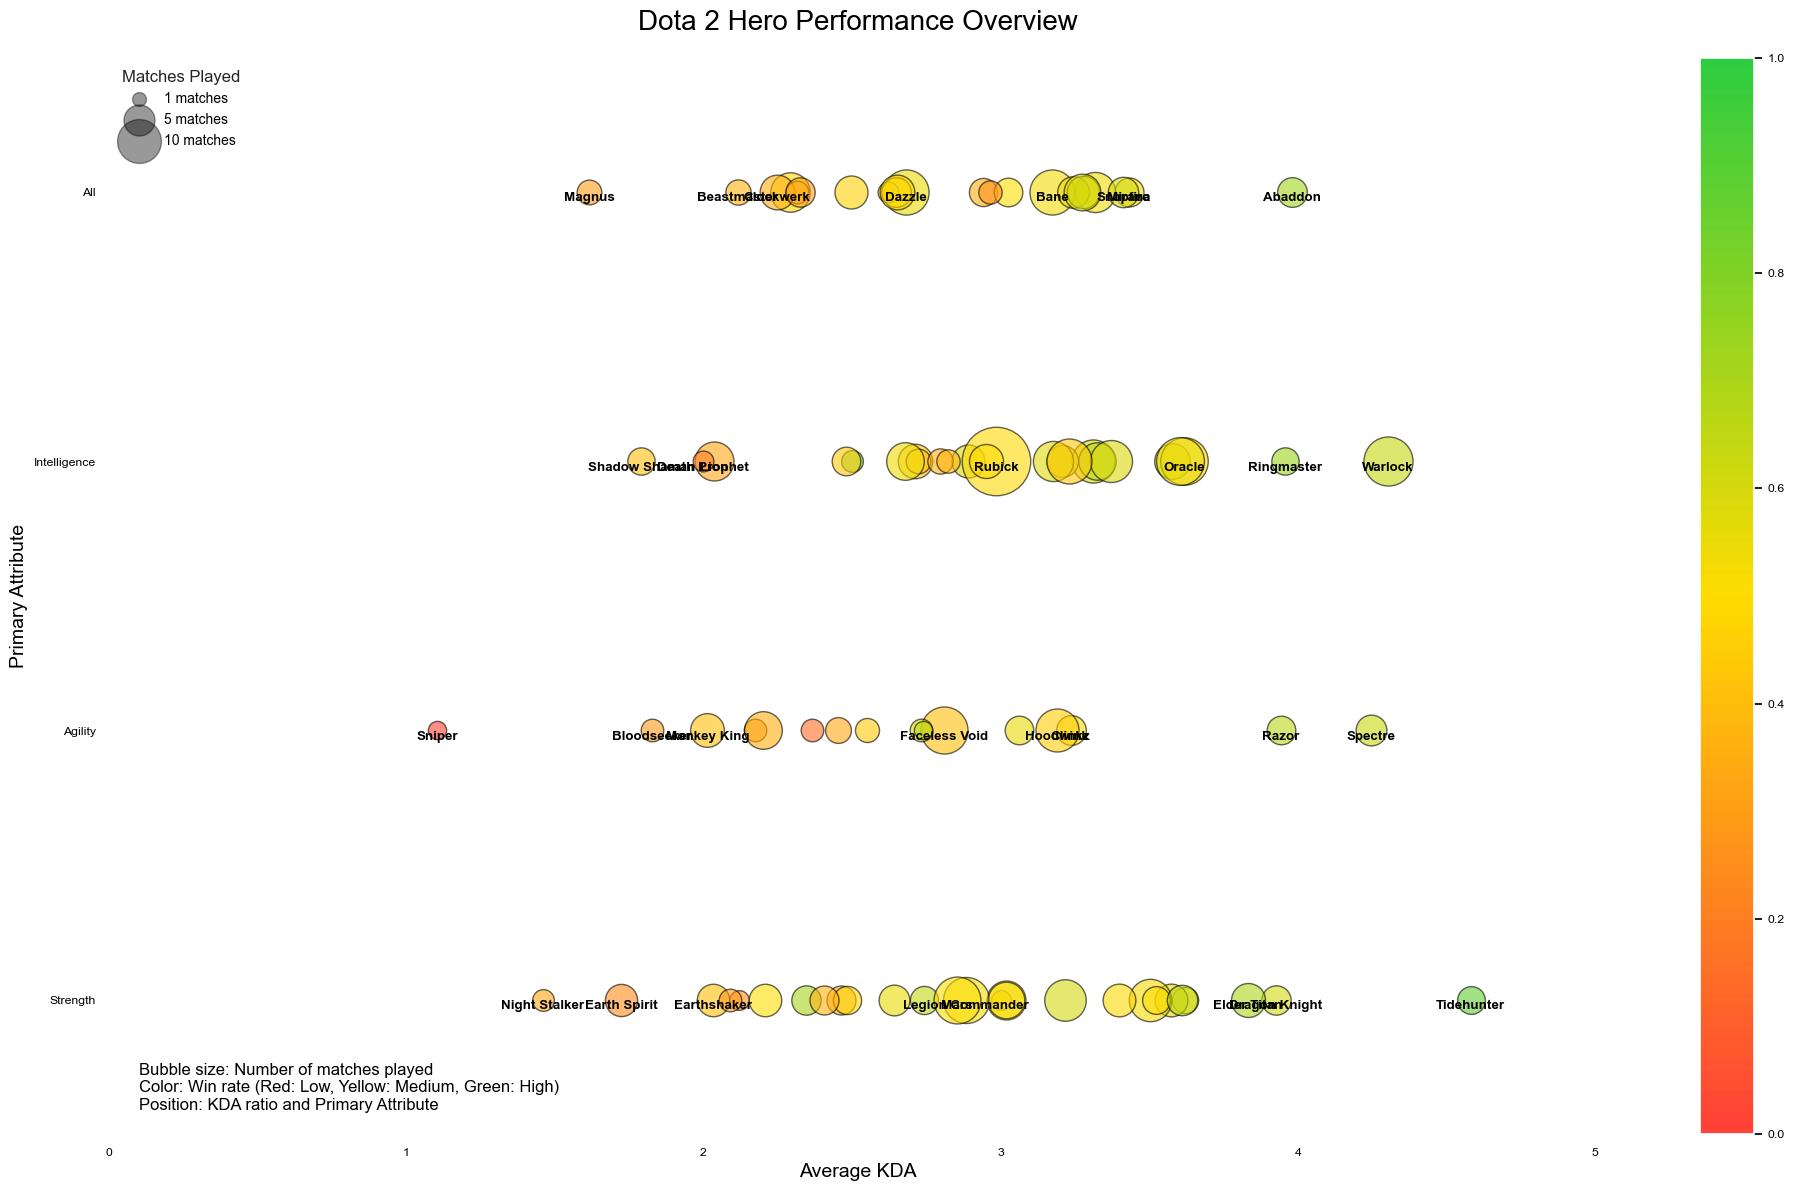

In [22]:
def get_hero_data(hero_id):
    return {
        'name': hero_data_mapping[hero_id]["name"] if hero_id in top_unique_heroes else "",
        'primary_attr': hero_data_mapping[hero_id]["attribute"]
    }

hero_data['hero_name'] = hero_data['hero_id'].apply(lambda x: get_hero_data(x)['name'])

# Map primary attributes to numeric values
attr_map = {'str': 0, 'agi': 1, 'int': 2, 'all': 3}
hero_data['attr_num'] = hero_data['primary_attr'].map(attr_map)

# Set up the plot
plt.figure(figsize=(20, 12), facecolor='white')
ax = plt.gca()
ax.set_facecolor('white')

# Custom color map for win rates
colors = ['#FF4136', '#FFDC00', '#2ECC40']
n_bins = 100
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# Plot bubbles and collect sizes for colorbar
scatter = []
for _, hero in hero_data.iterrows():
    color = cmap(hero['is_victory'])
    size = np.sqrt(hero['match_id']) * 100  # Adjust multiplier as needed
    x = hero['kda']
    y = hero['attr_num']
    scatter.append(plt.scatter(x, y, s=size, c=[color], alpha=0.6, edgecolors='black'))
    plt.annotate(hero['hero_name'], (x, y), ha='center', va='top', color='black', fontweight='bold')

# Customize the plot
plt.xlim(0, min(20, hero_data['kda'].max() * 1.1))
plt.ylim(-0.5, 3.5)
plt.yticks([0, 1, 2, 3], ['Strength', 'Agility', 'Intelligence', 'All'])
plt.xlabel('Average KDA', color='black', fontsize=14)
plt.ylabel('Primary Attribute', color='black', fontsize=14)
plt.tick_params(colors='black')

plt.title('Dota 2 Hero Performance Overview', color='black', fontsize=20, pad=20)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
sm.set_array([])  # You can use this if you don't have data directly
cbar = plt.colorbar(sm, ax=ax)  # Specify the ax to use
cbar.ax.yaxis.set_tick_params(color='black')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')

sizes = [100, 500, 1000]
legends = []
for size in sizes:
    legends.append(plt.scatter([], [], s=size, c='black', alpha=0.4, label=f'{size//100} matches'))
plt.legend(handles=legends, labelcolor='black', title='Matches Played', title_fontsize=12, fontsize=10, loc='upper left')

plt.text(0.02, 0.02, 'Bubble size: Number of matches played\nColor: Win rate (Red: Low, Yellow: Medium, Green: High)\nPosition: KDA ratio and Primary Attribute', 
         transform=ax.transAxes, color='black', fontsize=12, verticalalignment='bottom')

plt.tight_layout()
plt.savefig('dota2_hero_performance.png', dpi=600, bbox_inches='tight')
plt.show()


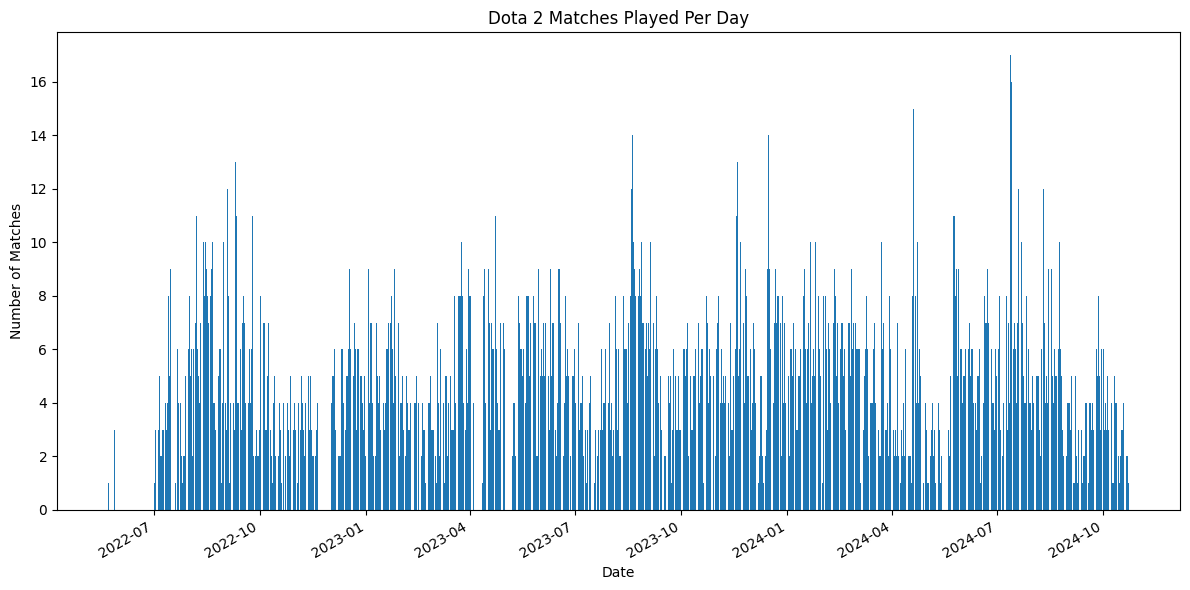

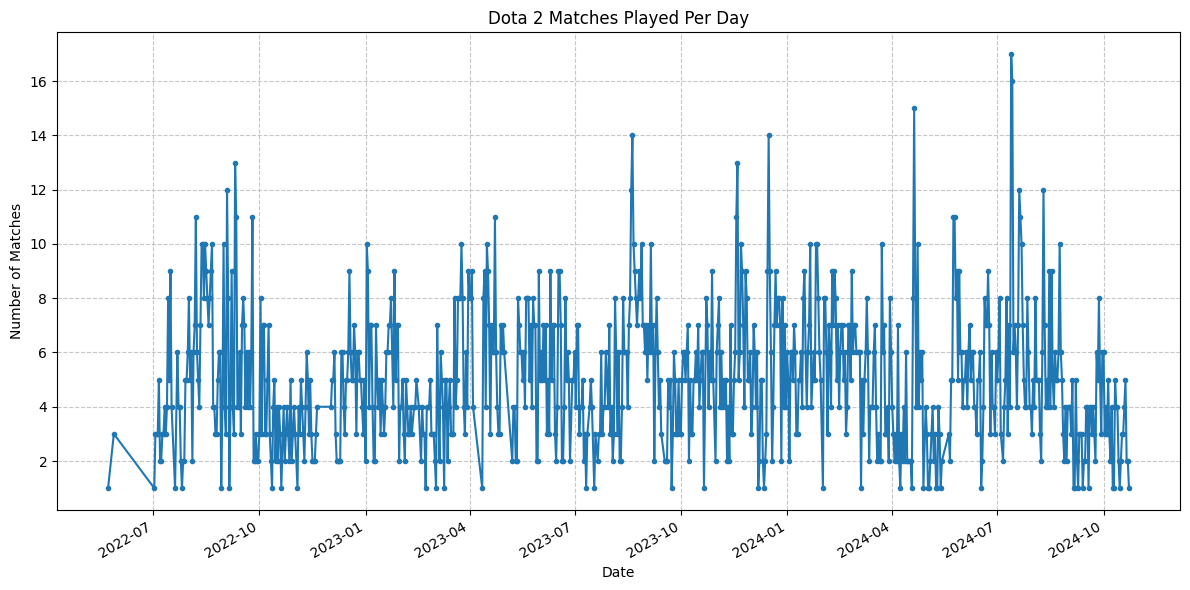

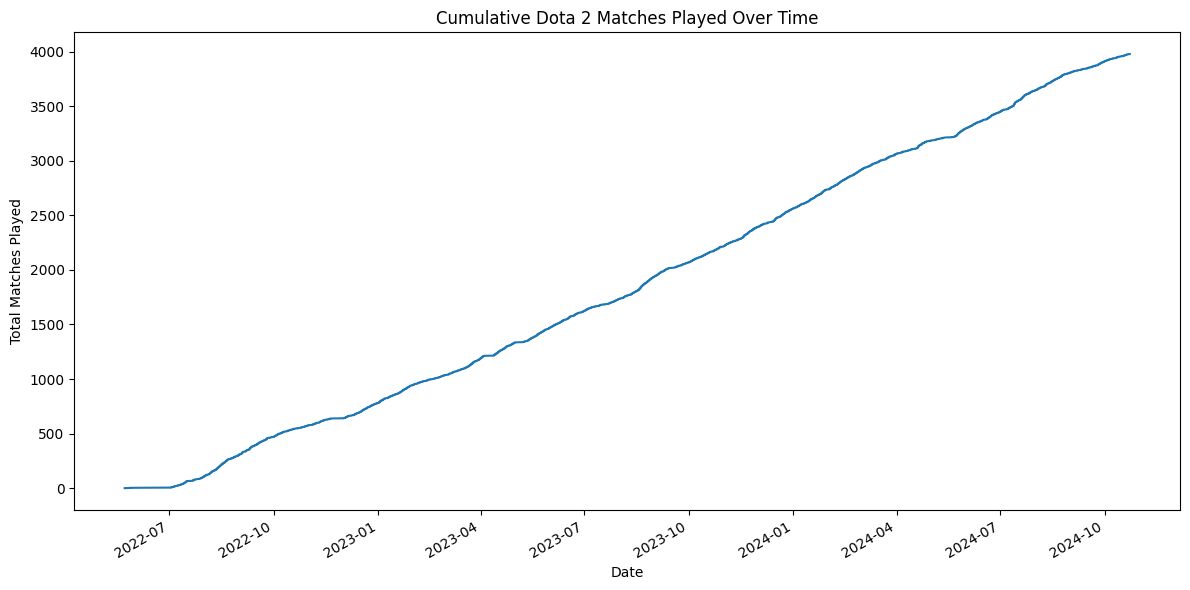


Match Statistics:
Total matches: 3977
Date range: 2022-05-23 to 2024-10-23
Average matches per day: 4.98
Max matches in a day: 17 (on 2024-07-13)
Total days played: 798
Win rate: 50.99%
Average K/D/A: 3.94/6.42/15.38


In [12]:
def plot_matches_analysis(df: pd.DataFrame):
    # Plot 1: Games played per day
    plt.figure(figsize=(12, 6))
    df_daily = df.groupby('date').size().reset_index(name='count')
    plt.bar(df_daily['date'], df_daily['count'])
    plt.title('Dota 2 Matches Played Per Day')
    plt.xlabel('Date')
    plt.ylabel('Number of Matches')
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Games played per day (Line Chart)
    plt.figure(figsize=(12, 6))
    df_daily = df.groupby('date').size().reset_index(name='count')
    plt.plot(df_daily['date'], df_daily['count'], marker='.')
    plt.title('Dota 2 Matches Played Per Day')
    plt.xlabel('Date')
    plt.ylabel('Number of Matches')
    plt.gcf().autofmt_xdate()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Plot 3: Cumulative games played over time
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['cumulative_matches'], marker='')
    plt.title('Cumulative Dota 2 Matches Played Over Time')
    plt.xlabel('Date')
    plt.ylabel('Total Matches Played')
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

plot_matches_analysis(df)

# Display some statistics
print("\nMatch Statistics:")
print(f"Total matches: {len(df)}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Average matches per day: {df.groupby('date').size().mean():.2f}")
print(f"Max matches in a day: {df.groupby('date').size().max()} (on {df.groupby('date').size().idxmax()})")
print(f"Total days played: {df['date'].nunique()}")
print(f"Win rate: {(df['is_victory'].sum() / len(df)) * 100:.2f}%")
print(f"Average K/D/A: {df['kills'].mean():.2f}/{df['deaths'].mean():.2f}/{df['assists'].mean():.2f}")

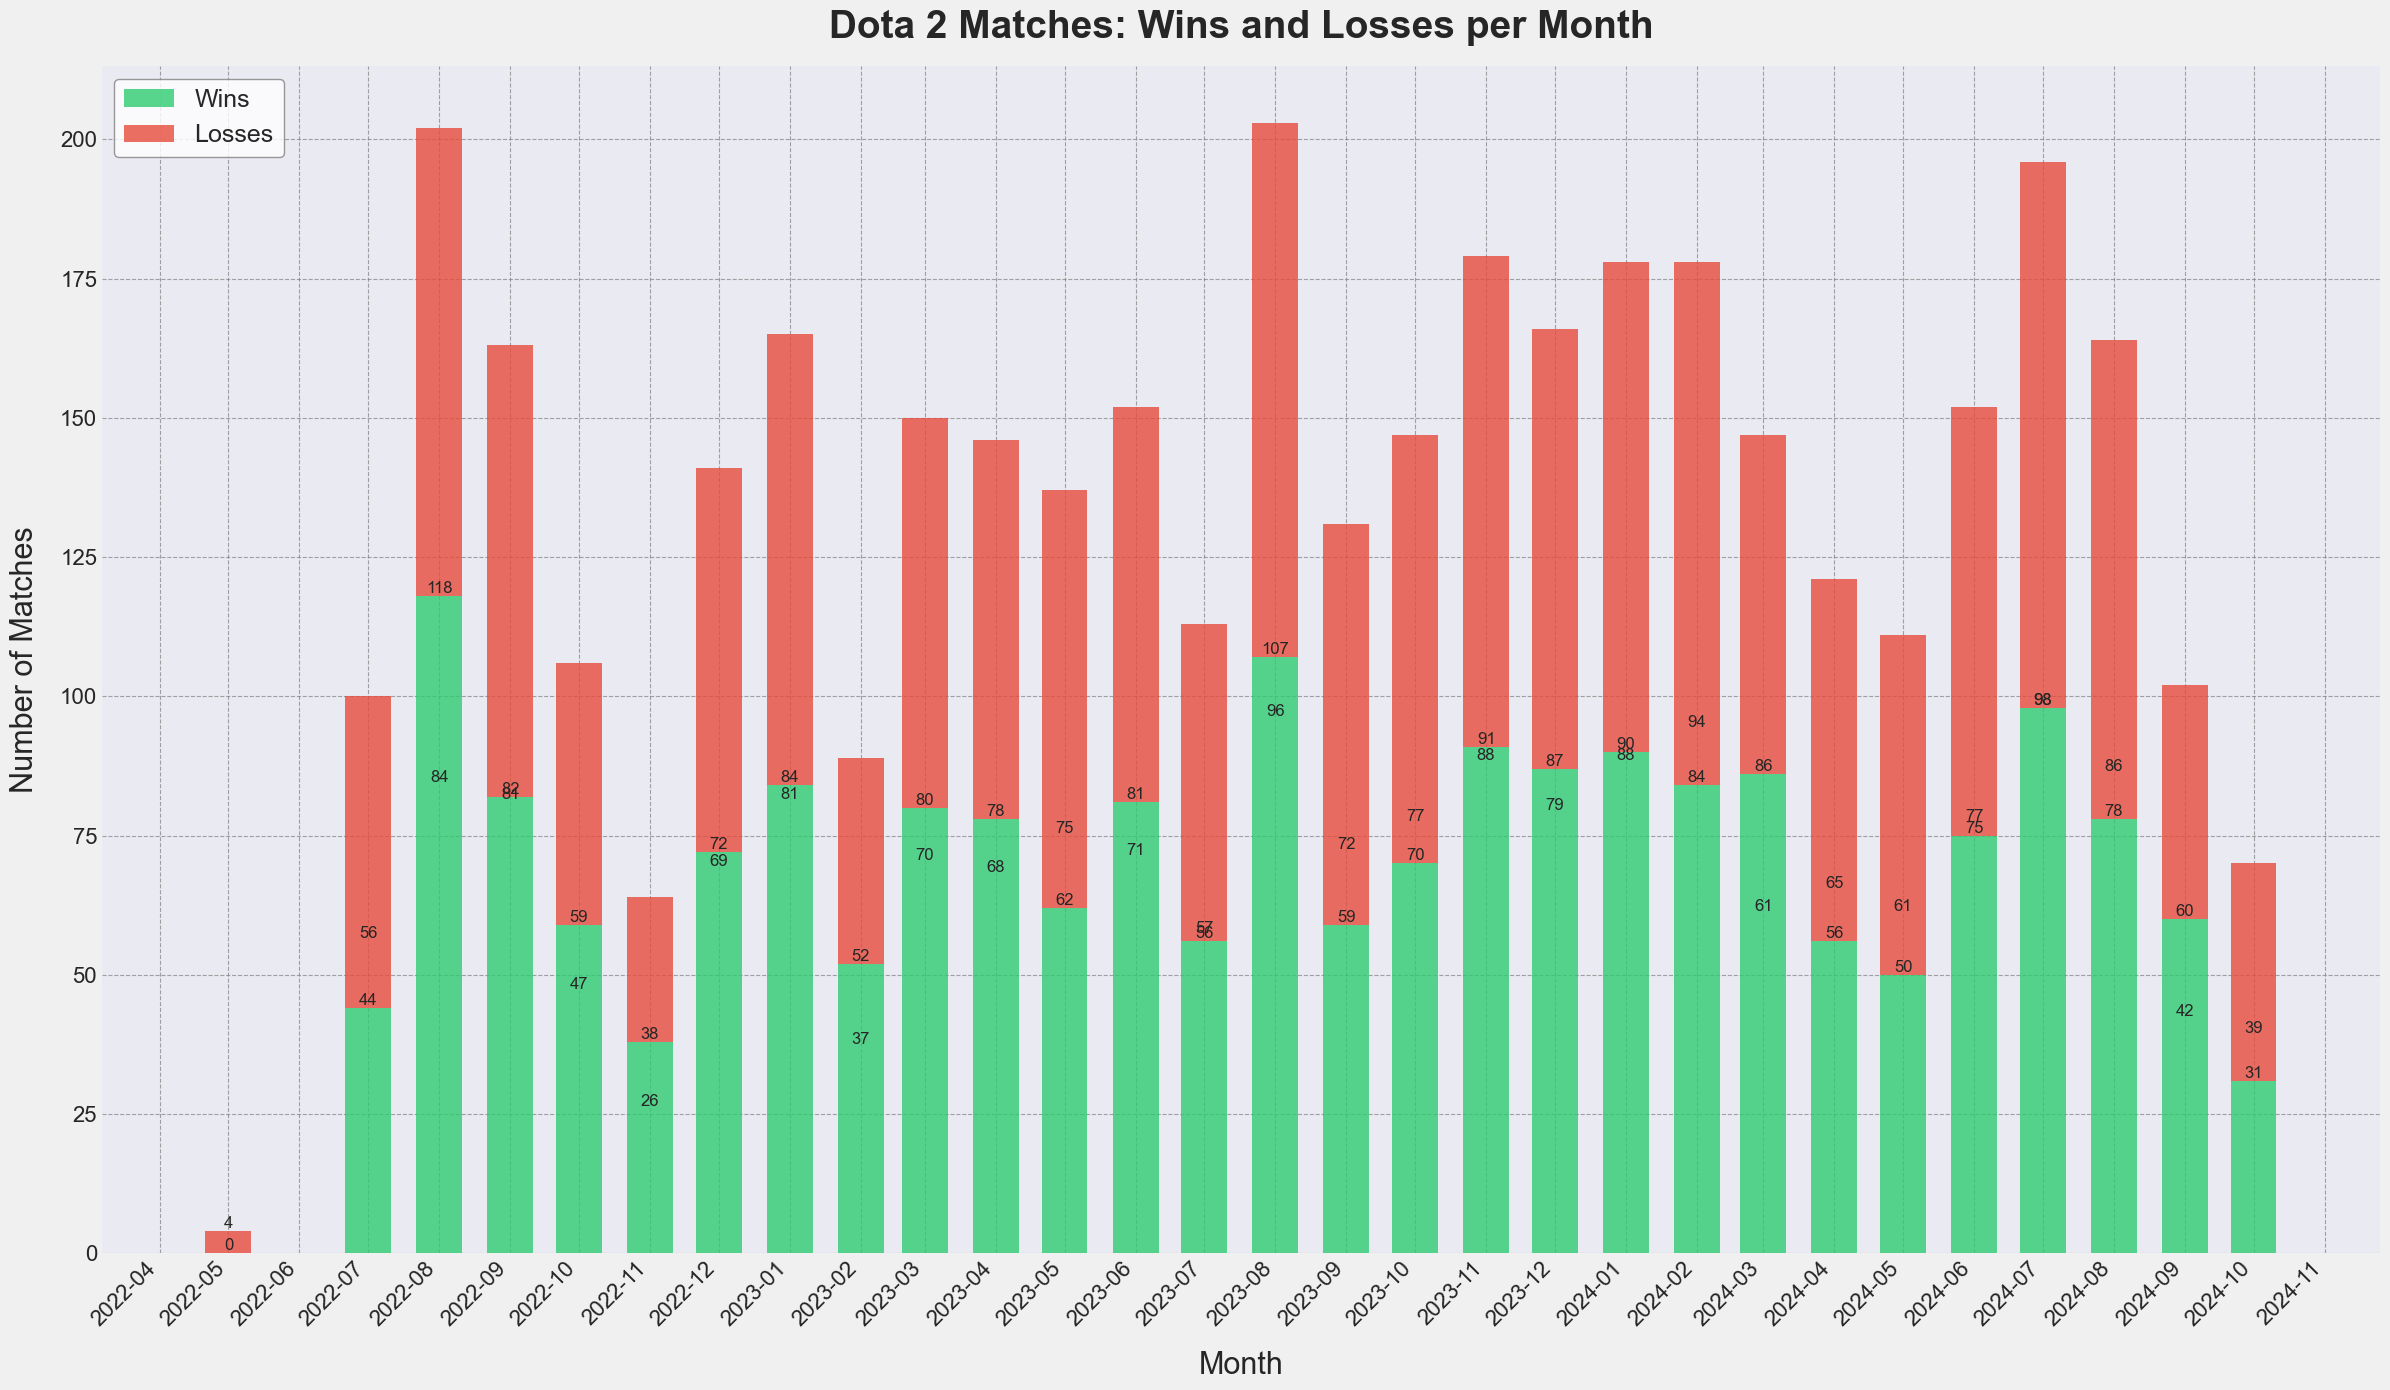

In [13]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("deep")

df['date'] = pd.to_datetime(df['date'])

# Group by month and aggregate data
df_monthly = df.groupby(df['date'].dt.to_period('M')).agg({
    'match_id': 'count',
    'is_victory': 'sum',
    'kills': 'mean',
    'deaths': 'mean',
    'assists': 'mean'
}).reset_index()

df_monthly.columns = ['date', 'total_matches', 'wins', 'avg_kills', 'avg_deaths', 'avg_assists']
df_monthly['date'] = df_monthly['date'].dt.to_timestamp()
df_monthly['losses'] = df_monthly['total_matches'] - df_monthly['wins']

# Sort by date to ensure chronological order
df_monthly = df_monthly.sort_values('date')

fig, ax = plt.subplots(figsize=(24, 14))

bars_wins = ax.bar(df_monthly['date'], df_monthly['wins'], label='Wins', color='#2ecc71', alpha=0.8, width=20)
bars_losses = ax.bar(df_monthly['date'], df_monthly['losses'], bottom=df_monthly['wins'], label='Losses', color='#e74c3c', alpha=0.8, width=20)

ax.set_title('Dota 2 Matches: Wins and Losses per Month', fontsize=28, fontweight='bold', pad=20)
ax.set_xlabel('Month', fontsize=22, labelpad=15)
ax.set_ylabel('Number of Matches', fontsize=22, labelpad=15)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
fig.autofmt_xdate(rotation=45)

ax.grid(True, linestyle='--', alpha=0.7, color='gray')

ax.tick_params(axis='both', which='major', labelsize=16)

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=12)

add_labels(bars_wins)
add_labels(bars_losses)

ax.legend(loc='upper left', fontsize=18, frameon=True, facecolor='white', edgecolor='gray')

fig.patch.set_facecolor('#f0f0f0')

plt.tight_layout()

plt.show()

/var/folders/57/v2_7d8m567n654mwmkhgh06h0000gp/T/ipykernel_78480/2067358577.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greens')


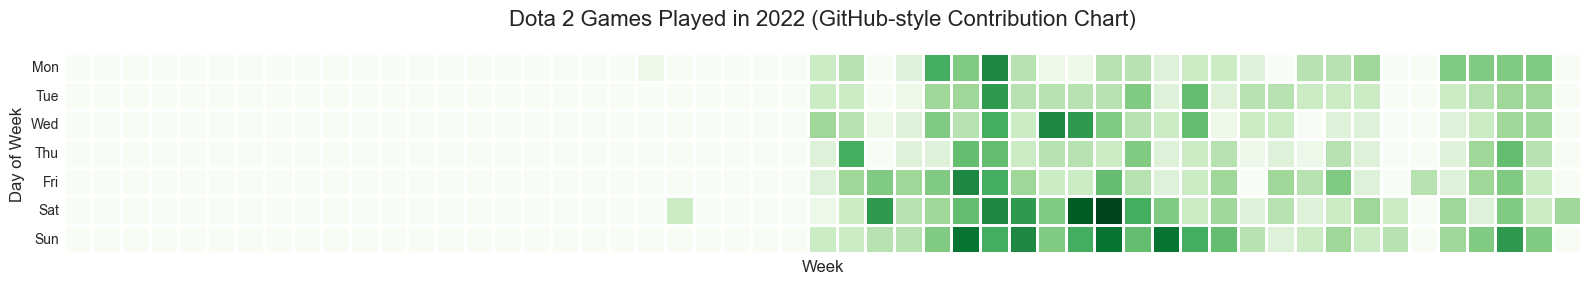

/var/folders/57/v2_7d8m567n654mwmkhgh06h0000gp/T/ipykernel_78480/2067358577.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greens')



Statistics for 2022:
Total games played: 780.0
Days played: 168
Days in period: 365
Play rate: 46.0% of days
Average games per day: 2.14
Average games on days played: 4.64
Max games in a day: 13 (on 2022-09-10, Saturday)




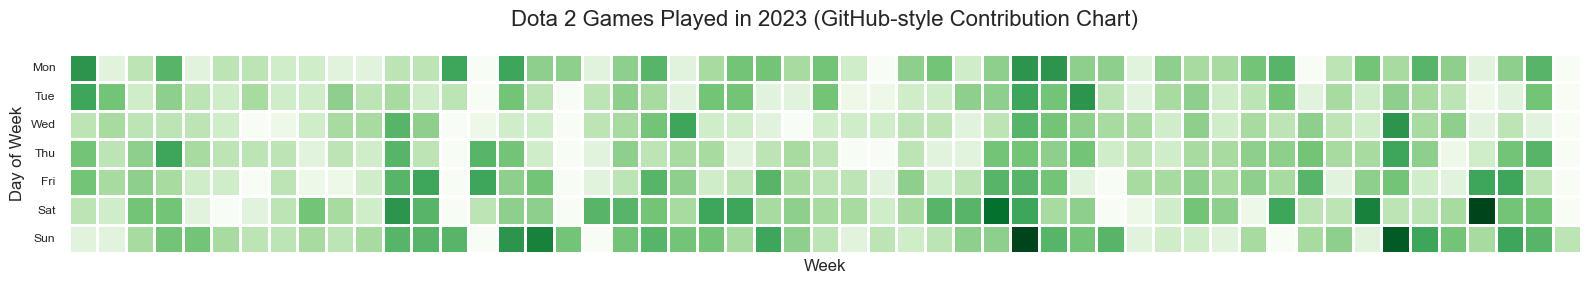


Statistics for 2023:
Total games played: 1778.0
Days played: 341
Days in period: 365
Play rate: 93.4% of days
Average games per day: 4.87
Average games on days played: 5.21
Max games in a day: 14 (on 2023-08-20, Sunday)




/var/folders/57/v2_7d8m567n654mwmkhgh06h0000gp/T/ipykernel_78480/2067358577.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greens')


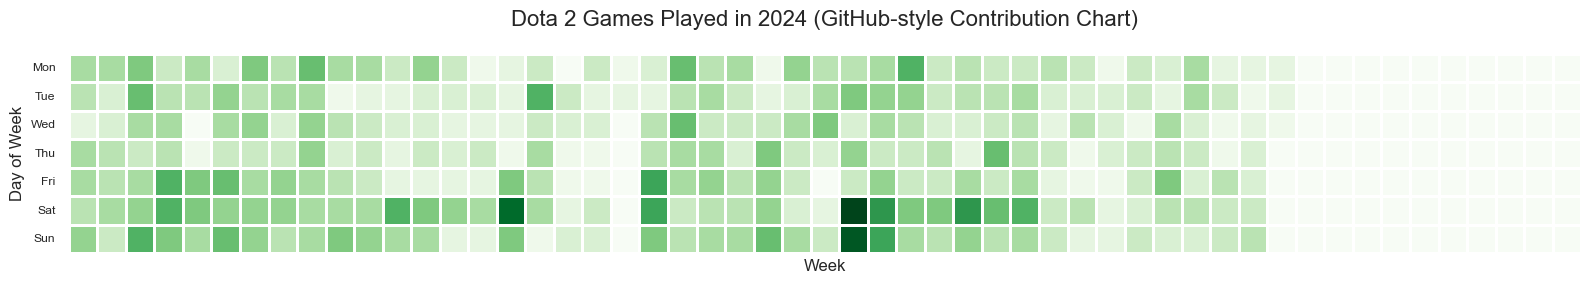


Statistics for 2024:
Total games played: 1419.0
Days played: 289
Days in period: 298
Play rate: 97.0% of days
Average games per day: 4.76
Average games on days played: 4.91
Max games in a day: 17 (on 2024-07-13, Saturday)




In [14]:
def create_yearly_waffle_charts(df: pd.DataFrame, years: list = None):
    """
    Create GitHub-style waffle charts showing Dota 2 games played per day for specified years
    
    Args:
        df: DataFrame containing match data with 'date' column
        years: List of years to generate charts for. If None, uses current year
    """
    # Ensure df['date'] is datetime
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])
    
    # If no years specified, use current year
    if years is None:
        years = [datetime.now().year]
    
    for year in years:
        start_date = pd.to_datetime(f"{year}-01-01")
        if year == datetime.now().year:
            end_date = pd.to_datetime(datetime.now(pytz.timezone('Asia/Kolkata')).date())
        else:
            end_date = pd.to_datetime(f"{year}-12-31")
        
        date_range = pd.date_range(start=start_date, end=end_date)
        all_dates_df = pd.DataFrame({'date': date_range, 'games': 0})
        
        all_dates_df['dayofweek'] = all_dates_df['date'].dt.dayofweek
        
        year_data = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
        games_per_day = year_data.groupby('date').size().reset_index(name='games')
        
        all_dates_df = all_dates_df.merge(games_per_day, on='date', how='left')
        all_dates_df['games'] = all_dates_df['games_y'].fillna(0)
        
        all_dates_df['week'] = (all_dates_df['date'] - start_date).dt.days // 7
        
        # Create the 7x53 grid
        data_grid = np.zeros((7, 53))
        
        for _, row in all_dates_df.iterrows():
            if row['week'] < 53:
                data_grid[row['dayofweek'], row['week']] = row['games']
        
        fig, ax = plt.subplots(figsize=(16, 8))
        sns.set(font_scale=0.8)
        
        cmap = plt.cm.get_cmap('Greens')
        max_games = max(all_dates_df['games'].max(), 1)
        norm = plt.Normalize(0, max_games)
        
        sns.heatmap(data_grid, ax=ax, cmap=cmap, norm=norm, square=True, 
                    cbar=False, linewidths=1, linecolor='white')
        
        ax.set_title(f'Dota 2 Games Played in {year} (GitHub-style Contribution Chart)', 
                    fontsize=16, pad=20)
        ax.set_xlabel('Week', fontsize=12)
        ax.set_ylabel('Day of Week', fontsize=12)
        
        ax.set_yticks(np.arange(7) + 0.5)
        ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 
                        rotation='horizontal')
        
        ax.set_xticks([])
        
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics for the year
        total_games = all_dates_df['games'].sum()
        days_played = (all_dates_df['games'] > 0).sum()
        
        print(f"\nStatistics for {year}:")
        print(f"Total games played: {total_games}")
        print(f"Days played: {days_played}")
        print(f"Days in period: {len(all_dates_df)}")
        print(f"Play rate: {(days_played/len(all_dates_df)*100):.1f}% of days")
        print(f"Average games per day: {total_games / len(all_dates_df):.2f}")
        print(f"Average games on days played: {total_games / max(days_played, 1):.2f}")
        
        if days_played > 0:
            max_games_info = all_dates_df.loc[all_dates_df['games'].idxmax()]
            max_date = max_games_info['date'].strftime('%Y-%m-%d')
            max_day = max_games_info['date'].strftime('%A')
            print(f"Max games in a day: {int(max_games_info['games'])} (on {max_date}, {max_day})")
        
        print("\n" + "="*50 + "\n")

create_yearly_waffle_charts(df, years=[2022, 2023, 2024])

Counter({23: 675, 22: 480, 0: 425, 20: 418, 3: 297, 2: 287, 19: 280, 1: 267, 21: 211, 4: 208, 18: 182, 17: 121, 5: 55, 16: 45, 15: 9, 14: 6, 13: 5, 6: 4, 12: 2})


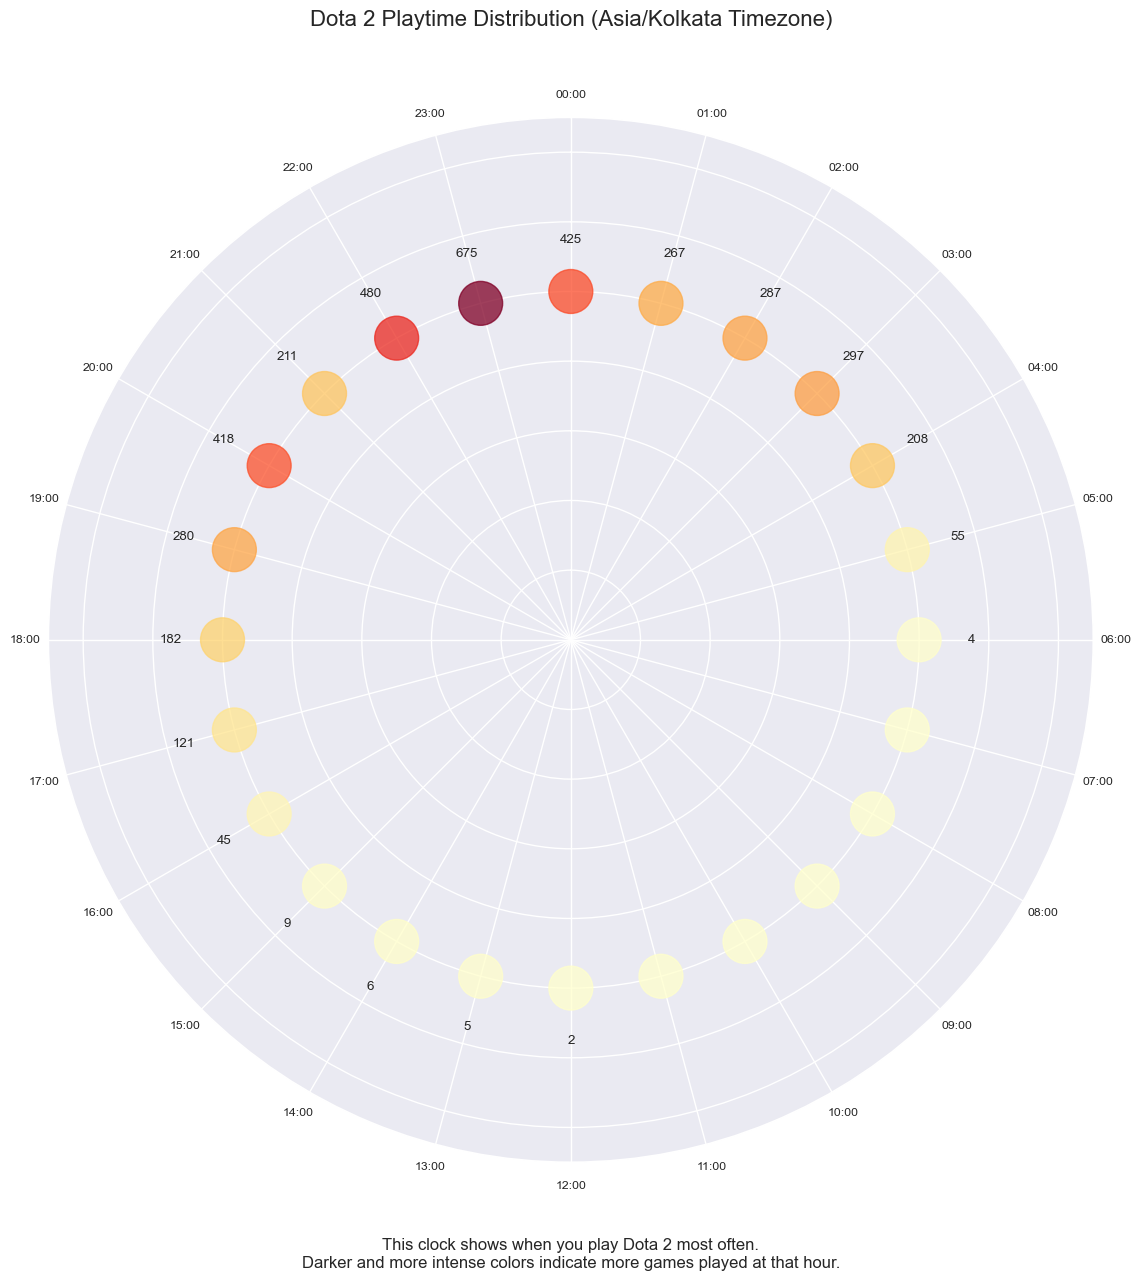

In [15]:
def visualize_playtime_polar(matches):
    # Customize timezone
    tz = pytz.timezone('Asia/Kolkata')
    
    hours = [datetime.fromtimestamp(match['endDateTime'], tz=pytz.utc).astimezone(tz).hour for match in matches]
    
    hour_counts = Counter(hours)
    print(hour_counts)
    
    # Prepare data for plotting
    theta = np.linspace(0, 2*np.pi, 24, endpoint=False)  # 24 hours in radians
    radii = [hour_counts[hour] for hour in range(24)]
    
    # Normalize radii for color mapping
    radii_norm = [(r - min(radii)) / (max(radii) - min(radii)) if max(radii) != min(radii) else 0.5 for r in radii]
    
    # Set up the polar plot
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))
    
    cmap = plt.get_cmap('YlOrRd')
    scatter = ax.scatter(theta, [1]*24, c=radii_norm, s=1000, cmap=cmap, alpha=0.75)
    
    ax.set_ylim(0, 1.5)
    ax.set_yticklabels([])
    ax.set_xticks(theta)
    ax.set_xticklabels([f"{h:02d}:00" for h in range(24)])
    ax.set_theta_zero_location("N")  # 00:00 at the top
    ax.set_theta_direction(-1)  # Clockwise
    
    for angle, radius, count in zip(theta, [1.15]*24, radii):
        if count > 0:
            ax.text(angle, radius, str(count), ha='center', va='center')
    
    plt.title("Dota 2 Playtime Distribution (Asia/Kolkata Timezone)", y=1.08, fontsize=16)

    fig.text(0.5, -0.05, 
             "This clock shows when you play Dota 2 most often.\n" 
             "Darker and more intense colors indicate more games played at that hour.",
             ha='center', fontsize=12, wrap=True)
    
    plt.tight_layout()
    plt.show()

visualize_playtime_polar(matches)

Hour       0   1   2   3   4   5   6   7   8   9   ...  14  15  16  17  18  \
Day                                                ...                       
Monday     53  43  62  45  28   7   0   0   0   0  ...   2   0   2   2  10   
Tuesday    49  39  39  28  18   2   0   0   0   0  ...   0   0   2   2  21   
Wednesday  52  33  40  30  17   4   0   0   0   0  ...   0   0   1   1  12   
Thursday   58  38  42  25  18   5   0   0   0   0  ...   0   0   1   6  15   
Friday     60  35  35  48  31  10   0   0   0   0  ...   0   0   1  13  28   
Saturday   75  36  39  61  49  17   2   0   0   0  ...   1   7  23  52  44   
Sunday     78  43  30  60  47  10   2   0   0   0  ...   3   2  15  45  52   

Hour       19  20  21  22   23  
Day                             
Monday     41  60  33  72   98  
Tuesday    39  45  33  83  106  
Wednesday  33  55  30  67   96  
Thursday   36  56  20  68   98  
Friday     41  73  35  64   81  
Saturday   43  67  34  63   96  
Sunday     47  62  26  63  100  


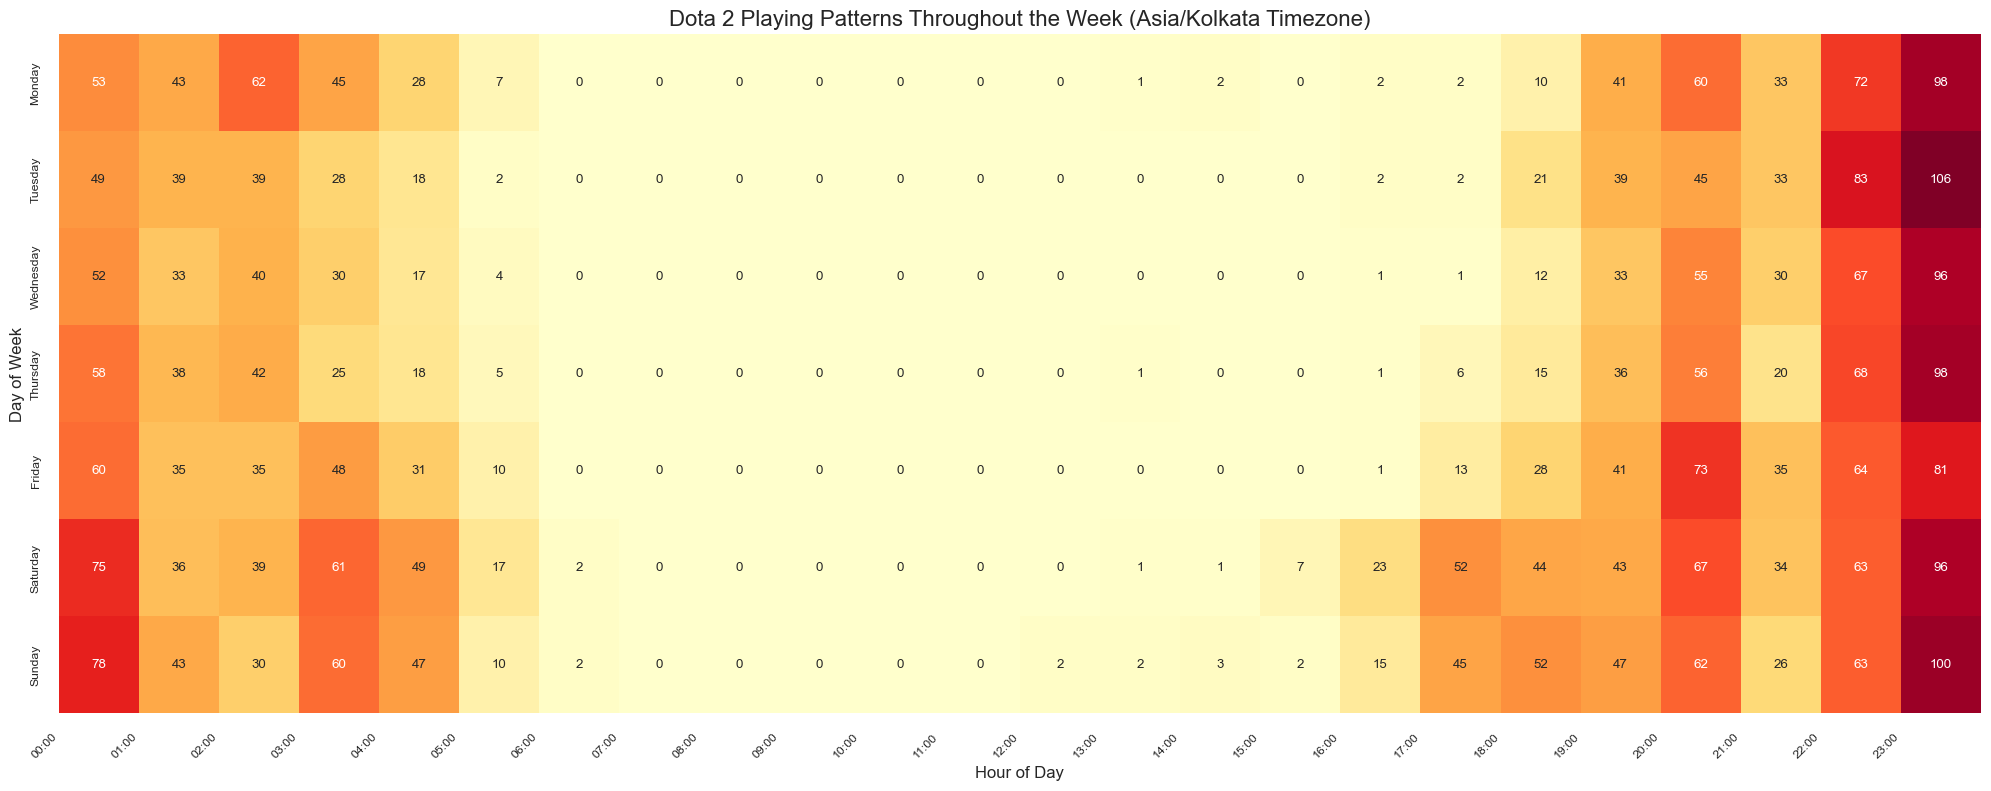


Total matches analyzed: 3977

Top 5 most active time slots:
Tuesday at 23:00 - 106 games
Sunday at 23:00 - 100 games
Monday at 23:00 - 98 games
Thursday at 23:00 - 98 games
Wednesday at 23:00 - 96 games


In [123]:
def visualize_weekly_hourly_heatmap(matches):
    # Customize timezone
    tz = pytz.timezone('Asia/Kolkata')
    
    # Extract day of week and hour of day from each match
    times = [datetime.fromtimestamp(match['endDateTime'], tz=pytz.utc).astimezone(tz) for match in matches]
    days = [t.strftime('%A') for t in times]  # Get day name
    hours = [t.hour for t in times]
    
    df = pd.DataFrame({'Day': days, 'Hour': hours})
    
    heatmap_data = df.groupby(['Day', 'Hour']).size().unstack(fill_value=0)
    
    # Ensure all hours are present
    all_hours = range(24)
    for hour in all_hours:
        if hour not in heatmap_data.columns:
            heatmap_data[hour] = 0

    heatmap_data = heatmap_data.sort_index(axis=1)
    
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    heatmap_data = heatmap_data.reindex(day_order)
    
    print(heatmap_data)
    
    # Set up the plot
    plt.figure(figsize=(20, 8))
    
    sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='d', cbar=False)
    
    plt.title('Dota 2 Playing Patterns Throughout the Week (Asia/Kolkata Timezone)', fontsize=16)
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Day of Week', fontsize=12)
    
    plt.xticks(range(24), [f'{i:02d}:00' for i in range(24)], rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    total_matches = len(matches)
    print(f"\nTotal matches analyzed: {total_matches}")
    print("\nTop 5 most active time slots:")
    top_5 = heatmap_data.stack().nlargest(5)
    for (day, hour), count in top_5.items():
        print(f"{day} at {hour:02d}:00 - {count} games")

visualize_weekly_hourly_heatmap(matches)

In [84]:
def create_animation(interp_data, date_range, output_filename):
    # Set the style to light theme
    plt.style.use('seaborn-v0_8')
    
    # Create custom color palette - warm colors for better contrast
    colors = ['#FF9999', '#FF6B6B', '#FF4C4C', '#FF3333', '#FF0000']
    custom_cmap = LinearSegmentedColormap.from_list('custom', colors)
    
    # Create figure with light background
    fig = plt.figure(figsize=(16, 10), dpi=100, facecolor='white')
    ax = fig.add_subplot(111, facecolor='white')
    
    # Set up tracking variables
    hero_stats_cache = {}
    previous_positions = {}
    changed_heroes_queue = deque(maxlen=20)
    persistent_top_heroes = set()
    
    def add_fancy_background():
        # Add gradient background
        background = Rectangle((0, 0), 1, 1, transform=ax.transAxes,
                            facecolor='white', zorder=-1)
        ax.add_patch(background)
        
        # Add subtle grid with custom styling
        ax.grid(True, linestyle='--', alpha=0.2, color='#666666')
        
        # Add custom spines
        for spine in ax.spines.values():
            spine.set_color('#cccccc')
            spine.set_linewidth(1)
    
    def add_label(hero, is_top=False):
        if is_top:
            bbox_props = dict(
                boxstyle="round,pad=0.3",
                fc='#f8f8f8',
                ec='#666666',
                alpha=0.9,
                lw=1
            )
            color = '#000000'
            fontweight = 'bold'
        else:
            bbox_props = dict(
                boxstyle="round,pad=0.2",
                fc='#f8f8f8',
                ec='#999999',
                alpha=0.7,
                lw=0.5
            )
            color = '#333333'
            fontweight = 'normal'
        
        ax.annotate(
            hero['heroName'],
            (hero['matches_played'], hero['win_rate'] * 100),
            xytext=(7, 7),
            textcoords='offset points',
            fontsize=9,
            color=color,
            fontweight=fontweight,
            bbox=bbox_props,
            zorder=5,
            animated=True
        )
    
    def calculate_change(current_pos, previous_pos):
        """Calculate the magnitude of change in position"""
        if previous_pos is None:
            return 0
        return np.sqrt(
            (current_pos[0] - previous_pos[0])**2 + 
            (current_pos[1] - previous_pos[1])**2
        )

    def update(frame):
        ax.clear()
        add_fancy_background()
        
        current_date = date_range[frame]
        
        if current_date not in hero_stats_cache:
            current_data = interp_data[interp_data['date'] <= current_date]
            hero_stats_cache[current_date] = current_data.groupby('heroId').last().reset_index()
        
        current_hero_stats = hero_stats_cache[current_date]
        current_max_matches = current_hero_stats['matches_played'].max()
        x_limit = max(current_max_matches * 1.2, 10)
        
        # Create scatter plot with light theme colors
        scatter = ax.scatter(
            current_hero_stats['matches_played'],
            current_hero_stats['win_rate'] * 100,
            s=current_hero_stats['matches_played'] * 2.5,
            c=np.arange(len(current_hero_stats)),
            cmap=custom_cmap,
            alpha=0.8,
            edgecolors='black',
            linewidths=1,
            zorder=4
        )
        
        # Track changes and update queue
        top_heroes = current_hero_stats.nlargest(15, 'matches_played')
        current_top_heroes = set(top_heroes['heroId'])
        
        for _, hero in current_hero_stats.iterrows():
            hero_id = hero['heroId']
            current_pos = (hero['matches_played'], hero['win_rate'] * 100)
            
            prev_pos = previous_positions.get(hero_id)
            change_magnitude = calculate_change(current_pos, prev_pos)
            
            if change_magnitude > 0.5:
                changed_heroes_queue.append((hero_id, frame))
            
            previous_positions[hero_id] = current_pos
        
        labeled_heroes = set()
        
        for _, hero in top_heroes.iterrows():
            add_label(hero, is_top=True)
            labeled_heroes.add(hero['heroId'])
        
        for hero_id, _ in changed_heroes_queue:
            if hero_id not in labeled_heroes:
                hero_data = current_hero_stats[current_hero_stats['heroId'] == hero_id]
                if not hero_data.empty:
                    add_label(hero_data.iloc[0], is_top=False)
                    labeled_heroes.add(hero_id)
        
        # Style axes with light theme
        ax.set_facecolor('white')
        ax.set_xlabel('Matches Played', fontsize=12, color='black', labelpad=10)
        ax.set_ylabel('Win Rate (%)', fontsize=12, color='black', labelpad=10)
        ax.set_title(f'Dota 2 Hero Performance\n{current_date.strftime("%Y-%m-%d %H:%M")}',
                    color='black', pad=20, fontweight='bold')
        
        ax.set_xlim(0, x_limit)
        ax.set_ylim(30, 100)
        ax.tick_params(colors='black', which='both')
        
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_color('black')
        
        return scatter,

    anim = animation.FuncAnimation(
        fig, 
        update, 
        frames=len(date_range),
        interval=50,
        blit=True
    )
    
    anim.save(
        output_filename,
        writer=animation.PillowWriter(
            fps=30,
            metadata=dict(artist='Me'),
        ),
    )
    
    plt.close(fig)

def generate_animation(matches, hero_data_mapping, output_filename='dota2_dynamic_animation.gif'):
    # Process data
    df = process_match_data(matches, hero_data_mapping)
    
    # Set figure parameters with light theme
    plt.rcParams['figure.figsize'] = [16, 10]
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['savefig.facecolor'] = 'white'
    
    # Generate animation
    interp_data, date_range = create_interpolated_data(df)
    create_animation(interp_data, date_range, output_filename)

# Run the animation
generate_animation(matches, hero_data_mapping)

/var/folders/57/v2_7d8m567n654mwmkhgh06h0000gp/T/ipykernel_45978/3687350385.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='24H')


In [93]:
def create_win_loss_animation(matches):
    patches = {
        '7.37': datetime(2024, 8, 14),
        '7.36': datetime(2024, 5, 22),
        '7.35': datetime(2023, 12, 14),
        '7.34': datetime(2023, 8, 8),
        '7.33': datetime(2023, 4, 20)
    }
    
    # Pre-process all data
    sorted_matches = sorted(matches, key=lambda x: x['endDateTime'])
    
    # Pre-calculate all data points
    dates = []
    net_wins = []
    current_net = 0
    win_rates = []
    total_wins = 0
    streaks = []
    current_streak = 0
    streak_type = None
    
    for i, match in enumerate(sorted_matches):
        is_victory = match['players'][0]['isVictory']
        dates.append(datetime.fromtimestamp(match['endDateTime']))
        current_net += (1 if is_victory else -1)
        net_wins.append(current_net)
        total_wins += 1 if is_victory else 0
        win_rates.append((total_wins / (i + 1)) * 100)
        
        if i == 0:
            current_streak = 1
            streak_type = 'winning' if is_victory else 'losing'
        else:
            prev_victory = sorted_matches[i-1]['players'][0]['isVictory']
            if is_victory == prev_victory:
                current_streak += 1
            else:
                current_streak = 1
                streak_type = 'winning' if is_victory else 'losing'
        streaks.append((current_streak, streak_type))
    
    # Filter patches within the match timeline
    start_date = min(dates)
    end_date = max(dates)
    relevant_patches = {
        version: date for version, date in patches.items()
        if start_date <= date <= end_date
    }
    
    # Calculate axis limits
    y_min = min(net_wins) - 2
    y_max = max(net_wins) + 2
    x_min = min(dates)
    x_max = max(dates)
    x_padding = timedelta(days=(x_max - x_min).days * 0.05)
    x_limits = (x_min - x_padding, x_max + x_padding)
    y_limits = (y_min, y_max)
    
    # Set up the plot
    plt.style.use('seaborn-v0_8')
    fig = plt.figure(figsize=(15, 8), facecolor='white')
    ax = plt.gca()
    
    # Initial setup
    main_line, = ax.plot([], [], color='#2ecc71', linewidth=2, zorder=3)
    scatter = ax.scatter([], [], c=[], s=50, zorder=4)
    
    # Create containers for patch visualization
    patch_lines = []
    patch_texts = []
    
    # Initialize patch lines and texts (hidden)
    for version, patch_date in relevant_patches.items():
        line = ax.axvline(x=patch_date, color='#3498db', 
                         linestyle='--', alpha=0, zorder=2)
        patch_lines.append(line)
        
        y_pos = y_max - (len(patch_texts) % 3) * (y_max - y_min) / 8
        text = ax.text(patch_date, y_pos, f'Patch {version}',
                      rotation=90, fontsize=8,
                      color='#3498db', alpha=0,
                      ha='right', va='bottom')
        patch_texts.append(text)
    
    # Create text elements
    title = ax.text(0.5, 1.05, '', horizontalalignment='center', 
                   transform=ax.transAxes, fontsize=14)
    streak_info = ax.text(0.02, 0.98, '', transform=ax.transAxes, 
                         fontsize=10, verticalalignment='top',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    win_rate_info = ax.text(0.98, 0.98, '', transform=ax.transAxes,
                           fontsize=10, horizontalalignment='right',
                           verticalalignment='top',
                           bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    # Set fixed elements
    ax.grid(True, linestyle='--', alpha=0.2, zorder=-1)
    for spine in ax.spines.values():
        spine.set_color('#333333')
        spine.set_linewidth(1)
    
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Net Wins', fontsize=12)
    
    def init():
        main_line.set_data([], [])
        scatter.set_offsets(np.c_[[], []])
        for line in patch_lines:
            line.set_alpha(0)
        for text in patch_texts:
            text.set_alpha(0)
        return [main_line, scatter, title, streak_info, win_rate_info] + patch_lines + patch_texts
    
    def update(frame):
        current_date = dates[frame]
        current_dates = dates[:frame+1]
        current_net_wins = net_wins[:frame+1]
        
        # Update main line and scatter
        main_line.set_data(current_dates, current_net_wins)
        main_line.set_color('#2ecc71' if current_net_wins[-1] >= 0 else '#e74c3c')
        
        colors = ['#2ecc71' if m['players'][0]['isVictory'] else '#e74c3c' 
                 for m in sorted_matches[:frame+1]]
        scatter.set_offsets(np.c_[current_dates, current_net_wins])
        scatter.set_color(colors)
        
        # Update patch lines visibility
        for i, (version, patch_date) in enumerate(relevant_patches.items()):
            if patch_date <= current_date:
                patch_lines[i].set_alpha(0.5)
                patch_texts[i].set_alpha(0.8)
            else:
                patch_lines[i].set_alpha(0)
                patch_texts[i].set_alpha(0)
        
        # Update text elements
        title.set_text('Dota 2 Win/Loss Progression\n'
                      f'Net Wins: {current_net_wins[-1]} ({frame + 1} games played)')
        
        current_streak, streak_type = streaks[frame]
        streak_info.set_text(f"Current {'Winning' if streak_type == 'winning' else 'Losing'} "
                           f"Streak: {current_streak}")
        
        win_rate_info.set_text(f'Win Rate: {win_rates[frame]:.1f}%')
        
        return [main_line, scatter, title, streak_info, win_rate_info] + patch_lines + patch_texts
    
    anim = animation.FuncAnimation(
        fig,
        update,
        init_func=init,
        frames=len(sorted_matches),
        interval=30,
        blit=True
    )
    
    anim.save('dota2_progression.gif',
              writer=animation.PillowWriter(fps=60),
              savefig_kwargs={'facecolor': 'white'})
    
    plt.close()

create_win_loss_animation(matches)